# SNN + Rastermap Demo

This notebook demonstrates the full pipeline from a spiking neural network (SNN) to Rastermap visualization.

**The pipeline:**
1. Load real neural spike data (rat hippocampus) as input to the SNN
2. Build a small 2-layer SNN using snntorch (LIF neurons)
3. Run the data through the SNN and record spike activations at each layer
4. Feed those activations into Rastermap to sort and visualize the neurons
5. Compare different Rastermap settings (locality=0 vs locality=0.75)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import snntorch as snn
from rastermap import Rastermap, utils
from scipy.stats import zscore

In [2]:
# load the hippocampus dataset
filename = utils.download_data(data_type="hippocampus")
dat = np.load(filename)

# spike matrix: neurons x time
spks = dat["spks"].astype("float32")
n_neurons, n_time = spks.shape
print(f"Data shape: {n_neurons} neurons x {n_time} timepoints")

# normalize
spks = zscore(spks, axis=1).astype("float32")

Data shape: 137 neurons x 10338 timepoints


## Build a Small SNN

We build a 2-layer SNN using Leaky Integrate-and-Fire (LIF) neurons from snntorch.
The network takes the 137 hippocampus neurons as input and passes them through
2 hidden layers of 256 LIF neurons each, recording the spike activations at every timestep.

In [7]:
# network dimensions
n_input = n_neurons # 137 — one input per hippocampus neuron
n_hidden = 256 # neurons per hidden layer
beta = 0.95 # membrane decay rate (how much voltage leaks per timestep)

# define the SNN
class SmallSNN(nn.Module):
    def __init__(self):
        super().__init__()
        # linear layers (weights)
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        
        # LIF neurons for each layer
        self.lif1 = snn.Leaky(beta=beta)
        self.lif2 = snn.Leaky(beta=beta)
    
    def forward(self, x, mem1, mem2):
        # layer 1
        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1, mem1)
        
        # layer 2
        cur2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(cur2, mem2)
        
        return spk1, spk2, mem1, mem2

model = SmallSNN()
print(model)

SmallSNN(
  (fc1): Linear(in_features=137, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (lif1): Leaky()
  (lif2): Leaky()
)


## Record Spike Activations

We run the hippocampus data through the SNN one timestep at a time,
recording the spike activations at each layer. This gives us two matrices
of shape (256 neurons x 10338 timepoints) - one per layer.

In [8]:
# store spike recordings for each layer
spk1_rec = []
spk2_rec = []

# initialize membrane potentials to zero
mem1 = torch.zeros(1, n_hidden)
mem2 = torch.zeros(1, n_hidden)

# run through data one timestep at a time (no training, just forward pass)
model.eval()
with torch.no_grad():
    for t in range(n_time):
        # get input at this timestep: shape (1, 137)
        x = torch.tensor(spks[:, t]).unsqueeze(0)
        
        # forward pass
        spk1, spk2, mem1, mem2 = model(x, mem1, mem2)
        
        # record spikes
        spk1_rec.append(spk1.squeeze(0).numpy())
        spk2_rec.append(spk2.squeeze(0).numpy())

# convert to numpy arrays: shape (n_hidden x n_time)
spk1_rec = np.array(spk1_rec).T  # (256 x 10338)
spk2_rec = np.array(spk2_rec).T  # (256 x 10338)

print(f"Layer 1 spikes shape: {spk1_rec.shape}")
print(f"Layer 2 spikes shape: {spk2_rec.shape}")
print(f"Layer 1 firing rate: {spk1_rec.mean():.3f}")
print(f"Layer 2 firing rate: {spk2_rec.mean():.3f}")

Layer 1 spikes shape: (256, 10338)
Layer 2 spikes shape: (256, 10338)
Layer 1 firing rate: 0.085
Layer 2 firing rate: 0.025


## Run Rastermap

We run Rastermap on the spike activations from each layer.
Since we have only 256 neurons we turn off clustering (n_clusters=None)
and sort individual neurons directly (like the hippocampus notebook in rastermap tutorial).

In [10]:
# run rastermap on layer 1
model_r1 = Rastermap(
    n_clusters=30,
    n_PCs=64,
    locality=0.75,
    time_lag_window=15,
    grid_upsample=10,
).fit(spk1_rec)

# run rastermap on layer 2
model_r2 = Rastermap(
    n_clusters=50,
    n_PCs=64,
    locality=0.75,
    time_lag_window=15,
    grid_upsample=0,
).fit(spk2_rec)

isort1 = model_r1.isort
isort2 = model_r2.isort

print("Rastermap done!")
print(f"isort1 shape: {isort1.shape}")
print(f"isort2 shape: {isort2.shape}")

2026-02-26 09:14:29,679 [INFO] normalizing data across axis=1
2026-02-26 09:14:29,691 [INFO] projecting out mean along axis=0
2026-02-26 09:14:29,701 [INFO] data normalized, 0.02sec
2026-02-26 09:14:29,702 [INFO] sorting activity: 256 valid samples by 10338 timepoints
2026-02-26 09:14:29,749 [INFO] n_PCs = 64 computed, 0.07sec
2026-02-26 09:14:29,758 [INFO] 16 clusters computed, time 0.08sec
2026-02-26 09:14:29,769 [INFO] clusters sorted, time 0.09sec
2026-02-26 09:14:29,773 [INFO] clusters upsampled, time 0.09sec
2026-02-26 09:14:29,781 [INFO] rastermap complete, time 0.10sec
2026-02-26 09:14:29,783 [INFO] normalizing data across axis=1
2026-02-26 09:14:29,789 [INFO] projecting out mean along axis=0
2026-02-26 09:14:29,795 [INFO] data normalized, 0.01sec
2026-02-26 09:14:29,796 [INFO] sorting activity: 248 valid samples by 10338 timepoints
2026-02-26 09:14:29,836 [INFO] n_PCs = 64 computed, 0.05sec
2026-02-26 09:14:29,848 [INFO] 26 clusters computed, time 0.07sec
2026-02-26 09:14:29,8

/Users/katelynsadorf/miniforge3/envs/rastermap/lib/python3.12/site-packages/rastermap/rastermap.py:278: RuntimeWarning: invalid value encountered in divide
  X /= stdx[:,np.newaxis]


## Visualize Sorted Spike Rasters

We plot the Rastermap-sorted spike activations for both layers,
with the rat's position overlaid so we can see if any neurons
show place-field-like structure.

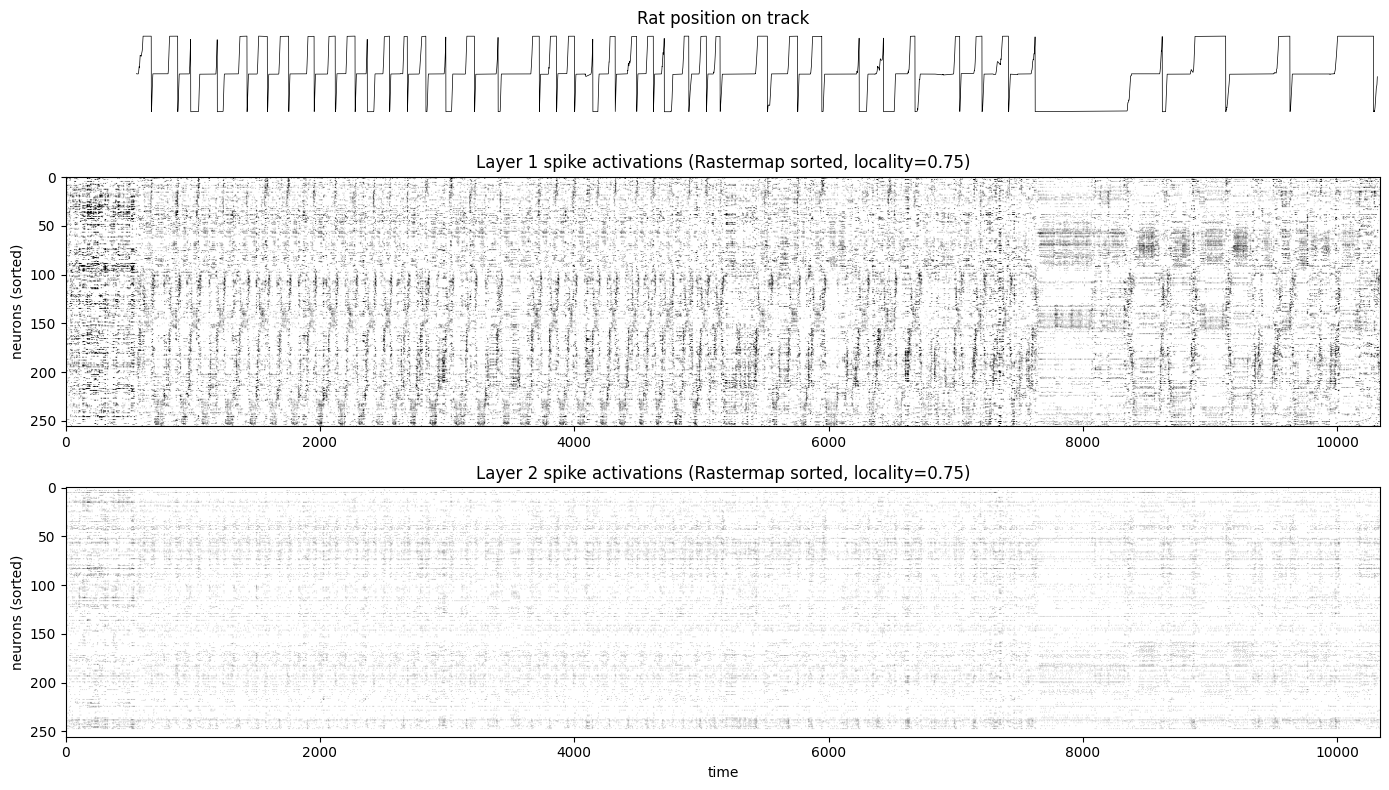

In [11]:
# load rat position for overlay
loc = dat["loc_signed"]  # rat's position on the track over time

fig, axes = plt.subplots(3, 1, figsize=(14, 8), 
                          gridspec_kw={"height_ratios": [1, 3, 3]})

# plot rat position
axes[0].plot(loc, color="black", linewidth=0.5)
axes[0].set_xlim([0, n_time])
axes[0].set_ylabel("position")
axes[0].set_title("Rat position on track")
axes[0].axis("off")

# plot layer 1 sorted spikes
axes[1].imshow(spk1_rec[isort1], cmap="gray_r", vmin=0, vmax=0.3, aspect="auto")
axes[1].set_ylabel("neurons (sorted)")
axes[1].set_title("Layer 1 spike activations (Rastermap sorted, locality=0.75)")

# plot layer 2 sorted spikes
axes[2].imshow(spk2_rec[isort2], cmap="gray_r", vmin=0, vmax=0.3, aspect="auto")
axes[2].set_ylabel("neurons (sorted)")
axes[2].set_title("Layer 2 spike activations (Rastermap sorted, locality=0.75)")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.savefig("raster_locality075.png", dpi=150, bbox_inches="tight")
plt.show()

2026-02-26 09:17:14,048 [INFO] normalizing data across axis=1
2026-02-26 09:17:14,054 [INFO] projecting out mean along axis=0
2026-02-26 09:17:14,062 [INFO] data normalized, 0.01sec
2026-02-26 09:17:14,063 [INFO] sorting activity: 256 valid samples by 10338 timepoints
2026-02-26 09:17:14,109 [INFO] n_PCs = 64 computed, 0.06sec
2026-02-26 09:17:14,118 [INFO] 16 clusters computed, time 0.07sec
2026-02-26 09:17:14,128 [INFO] clusters sorted, time 0.08sec
2026-02-26 09:17:14,132 [INFO] clusters upsampled, time 0.08sec
2026-02-26 09:17:14,140 [INFO] rastermap complete, time 0.09sec


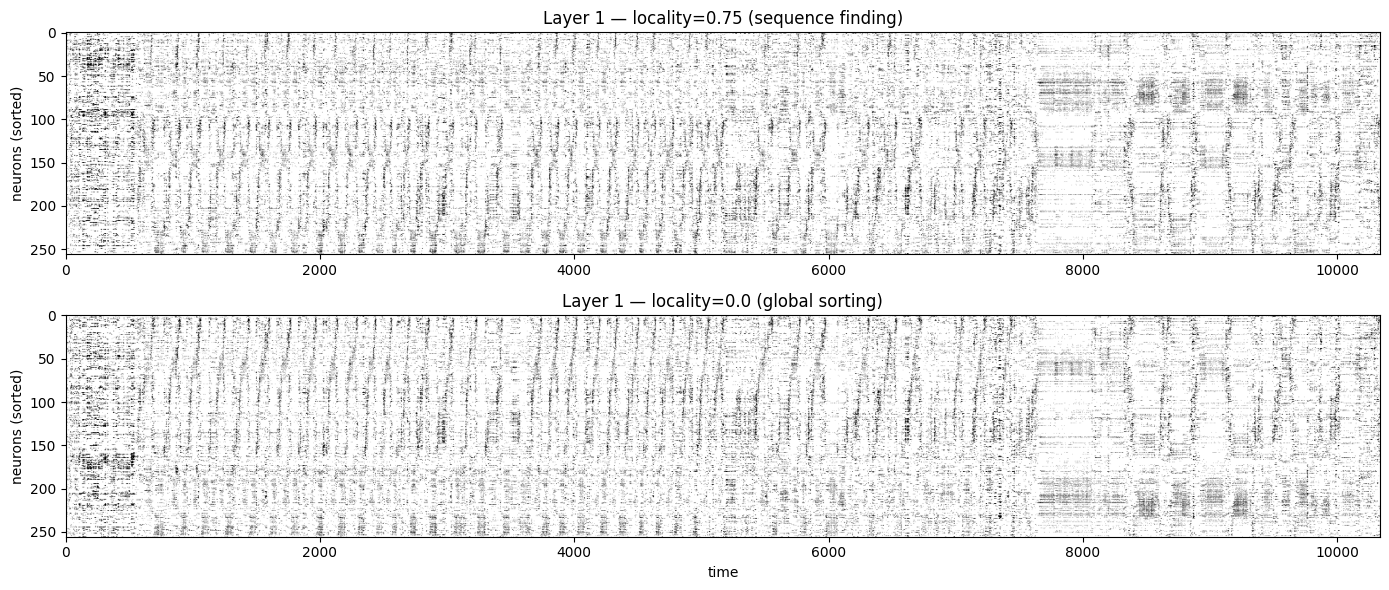

In [14]:
# rerun rastermap on layer 1 with locality=0 for comparison
model_r1_global = Rastermap(
    n_clusters=30,
    n_PCs=64,
    locality=0.0,
    time_lag_window=15,
    grid_upsample=10,
).fit(spk1_rec)

isort1_global = model_r1_global.isort

# plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].imshow(spk1_rec[isort1], cmap="gray_r", vmin=0, vmax=0.3, aspect="auto")
axes[0].set_ylabel("neurons (sorted)")
axes[0].set_title("Layer 1 — locality=0.75 (sequence finding)")

axes[1].imshow(spk1_rec[isort1_global], cmap="gray_r", vmin=0, vmax=0.3, aspect="auto")
axes[1].set_ylabel("neurons (sorted)")
axes[1].set_title("Layer 1 — locality=0.0 (global sorting)")
axes[1].set_xlabel("time")

plt.tight_layout()
plt.savefig("raster_locality_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary

This notebook demonstrated the full SNN → Rastermap pipeline:

1. **Data**: 137 rat hippocampus neurons (10,338 timepoints) used as input
2. **SNN**: 2-layer LIF network (256 neurons/layer, beta=0.95) built with snntorch
3. **Spike recording**: Layer 1 firing rate ~9%, Layer 2 ~2.6% - signal naturally 
   gets sparser in deeper layers of an untrained network
4. **Rastermap**: Successfully sorted neurons in both layers, revealing that Layer 1 
   picks up structure from the input while Layer 2 (too sparse) shows little structure
5. **Locality comparison**: locality=0.75 vs locality=0.0 produces different orderings 
   of the same neurons - high locality emphasizes sequential patterns, low locality 
   emphasizes global co-firing